In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
eq_df = pd.read_csv('tempdata/since_1980.csv')

In [3]:
#Add column for year
years = []
for time in eq_df['origintime']:
    year = int(str.split(time, '-')[0])
    years.append(year)
    #index = time.key
year_column = pd.Series(years, index=eq_df.index)
eq_df['year'] = year_column

In [4]:
eq_df.head()

,Unnamed: 0,id,origintime,latitude,longitude,depth,err_lon,err_lat,err_depth,err_origintime,county,origin_src,prefmag,pmag_type,pmag_src,mw,mw_src,mblg_ogs,mblg_usgs,ml_ogs,m3hz_ogs,md_ogs,mb,ms,mfa,max_mmi,reafile,reamtime,geom,pdlid,mw_ogs,year
0,0,255,1980-01-05 07:11:31.21,35.586,-97.894,5,NaN,NaN,NaN,NaN,CANADIAN,OGS,1.9,M3Hz,OGS,NaN,NaN,1.6,NaN,NaN,1.9,1.7,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E6100000F0A7C64B377958C05EBA490C02CB...,NaN,NaN,1980
1,1,256,1980-01-12 07:12:56.45,36.453,-97.642,5,NaN,NaN,NaN,NaN,GARFIELD,OGS,1.7,M3Hz,OGS,NaN,NaN,NaN,NaN,NaN,1.7,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000000C022B87166958C0448B6CE7FB39...,NaN,NaN,1980
2,2,257,1980-02-03 00:46:30.05,33.994,-97.463,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.2,M3Hz,OGS,NaN,NaN,1.9,NaN,NaN,2.2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000001283C0CAA15D58C0AC1C5A643BFF...,NaN,NaN,1980
3,3,258,1980-02-05 04:32:35.45,34.046,-97.451,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.1,M3Hz,OGS,NaN,NaN,2.3,NaN,NaN,2.1,1.9,NaN,NaN,NaN,3,NaN,NaN,0101000020E6100000BE9F1A2FDD5C58C0D9CEF753E305...,NaN,NaN,1980
4,4,259,1980-03-09 03:57:10.56,35.100,-95.100,5,NaN,NaN,NaN,NaN,HASKELL,OGS,1.2,M3Hz,OGS,NaN,NaN,1.4,NaN,NaN,1.2,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000006666666666C657C0CDCCCCCCCC8C...,NaN,NaN,1980


# Miscellaneous things to add to final notebook

#0.1 Additional Imports

In [5]:
import datetime
import statsmodels.api as sm

#0.2 Poisson Process Code

#0.2.1 No Recent Changes

In [6]:
#function to create list of interarrival times in hours from df 
#1
def get_hours_between(df):
    dates=[]
    origintimes = df.origintime.values
    for date in origintimes:
        year, month, day = date.split('-')
        day, hour = day.split(' ')
        hour, minute, second = hour.split(':')
        if len(second.split('.'))==2:
            second, microsecond = second.split('.')
        elif len(second.split('.'))==1:
            microsecond=0
        dates.append(datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), 
                                       int(second), int(microsecond)))
    dates=sorted(dates)
    deltas=[]
    for i in range(1,len(dates)):
        delta = dates[i] - dates[i-1]
        delta = delta.total_seconds()/3600
        deltas.append(delta)
    deltas = np.array(deltas)
    return deltas

#0.2.2 Recent Changes, Need to add to Final

In [38]:
#2
#fit and plot exponential to data
#k is manual assessment of number of parameters
def fit_expo(deltas, bins=100, xmax=100, ymax=0.02, k=1):
    #Use Maxmimum Likelihood Estimator to get exponential fit
    expo_fit = sp.stats.expon.fit(deltas, floc=0)
    
    #Calculate Summary Statistics
    mean = np.mean(deltas) #sample mean
    lambd = expo_fit[1] #fitted mean
    n = len(deltas)
    ks_d, ks_pval=sp.stats.kstest(deltas, 'expon', alternative='two-sided')
    ppstats = sp.stats.probplot(deltas, dist='expon')
    r = ppstats[1][2]
    r2 = r**2
    log_lik = n*np.log(lambd) - 2*lambd*np.sum(deltas)
    aic = 2*k - log_lik
    
    #Overlay fitted exponential over histogram
    plt.hist(deltas, bins=bins, normed=True)
    x = np.arange(0,xmax,0.01)
    y = sp.stats.expon.pdf(x, scale=lambd)
    plt.plot(x,y)
    plt.xlim([0,xmax])
    plt.ylim([0,ymax])
    
    #QQ Plot for fit to exponential
    sm.qqplot(deltas, dist='expon', fit=True, line='45')
    plt.show()
    
    #Print Summary Statistics
    print "lambda=" + str(lambd)
    print "mean(data)=" + str(mean)
    print "sample size=" + str(n)
    print "Kolmogorov-Smirnov Test Statistic D=" + str(ks_d)
    print "Kolmogorov-Smirnov Test p-value" + str(ks_pval)
    print "QQ R^2 =" + str(r2)
    print "AIC=" + str(aic) + "(NEED TO CHECK THIS IN R)" 
    print "AICc=" 
    return(lambd, mean, n, ks_d, ks_pval, r2, aic)

In [22]:
k=1
lambd=4
x=np.array([25,2,123])
n=len(x)
log_lik = n*np.log(lambd) - lambd*np.sum(x)
aic = 2*k - log_lik
log_lik, log_lik2, aic

(-595.84111691664032, -595.84111691664032, 597.84111691664032)

In [36]:
#3
#get interarrival times for whole df
def show_expo_fit(df, bins=40, xmax=10000, ymax=0.001):
    deltas = get_hours_between(df)
    fit = fit_expo(deltas, bins=bins, xmax=xmax, ymax=ymax)

Note: Could also fit to Poisson

Note: Look into "fit" algorithm in scipy, statsmodels

Note: Is this the standard plot for showing distributional fit? 

Note: Need to look into understanding QQ Plots and Probability Plots

Use AIC for comparing distributional fit.

    *Starting Point: Given taht this is the correct distribution, what is the log-likelihood of the data?
    
    *if the number of data points is small, then some correction is often necessary (see AICc, below).
    
    *\mathrm{AIC} = 2k - 2\ln(L)
    *Important websites: http://www.easydatascience.com
    *http://stats.stackexchange.com/questions/31768/is-it-okay-to-compare-fitted-distributions-with-the-aic

Look into nonparametric methods for simulating the distribution here.

Look into this further: http://www.geos.ed.ac.uk/homes/abell5/Modelcode.html

Power Law as a Model for Earthquakes

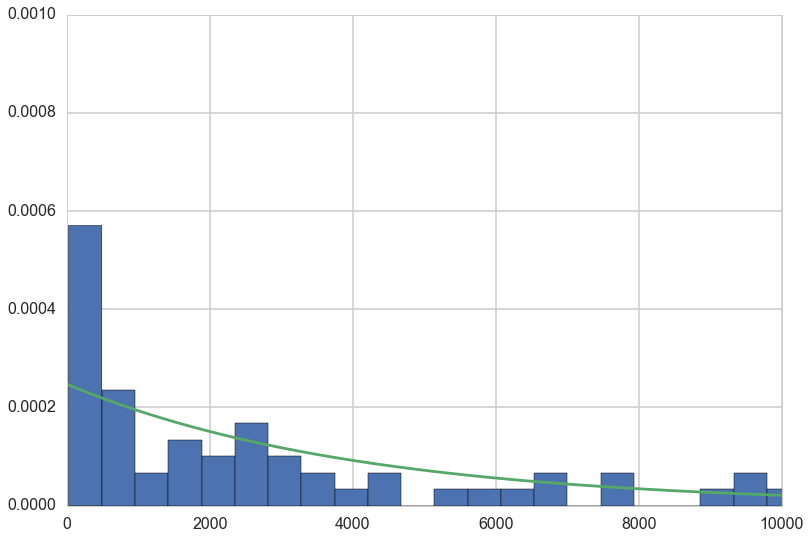

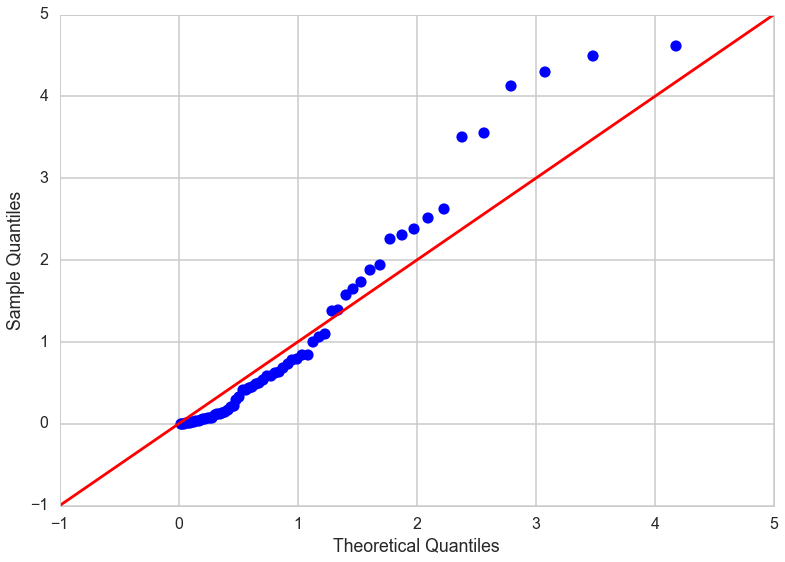

lambda=4048.4588911
mean(data)=4048.45867622
sample size=64
Kolmogorov-Smirnov Test Statistic D=0.999999949153
Kolmogorov-Smirnov Test p-value0.0
QQ R^2 =0.966139571152
AIC=1048960655.88(NEED TO CHECK THIS IN R)


In [37]:
show_expo_fit(eq_df[(eq_df.prefmag>=3) & (eq_df.year<2010)])